In [1]:
!pip install -U folium
!pip install -U branca
!pip install geopandas

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash

In [2]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re
import requests
import json
import folium

In [3]:
data= pd.read_csv("/project/shanti_data/data.csv")

<AxesSubplot:>

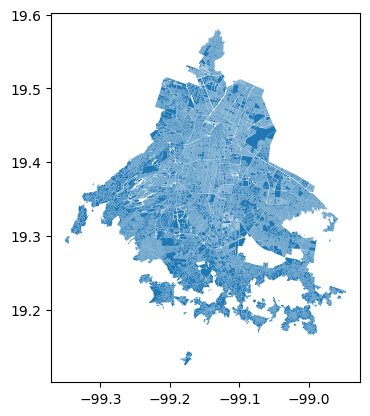

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

blocks = gpd.read_file('/project/blocks/poligono_manzanas_cdmx.shp')
blocks.plot()

plt.show()

In [ ]:
blocks.set_crs("EPSG:4326", inplace=True)

In [ ]:
from shapely.geometry import Point
# Create a GeoDataFrame from your existing DataFrame
data['geometry'] = data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# Set the coordinate reference system (CRS) to be the same as the blocks
# This is necessary for the spatial join to work correctly
gdf.set_crs(blocks.crs, inplace=True)

# Perform the spatial join
joined = gpd.sjoin(gdf, blocks, how='left', op='intersects')

# The result is a new GeoDataFrame that includes all columns from the original DataFrame,
# plus additional columns for each attribute in the shapefile for the block that each point falls within.

## Zoom into the Downtown 

<AxesSubplot:>

<AxesSubplot:>

(-99.1, -99.2)

(19.4, 19.5)

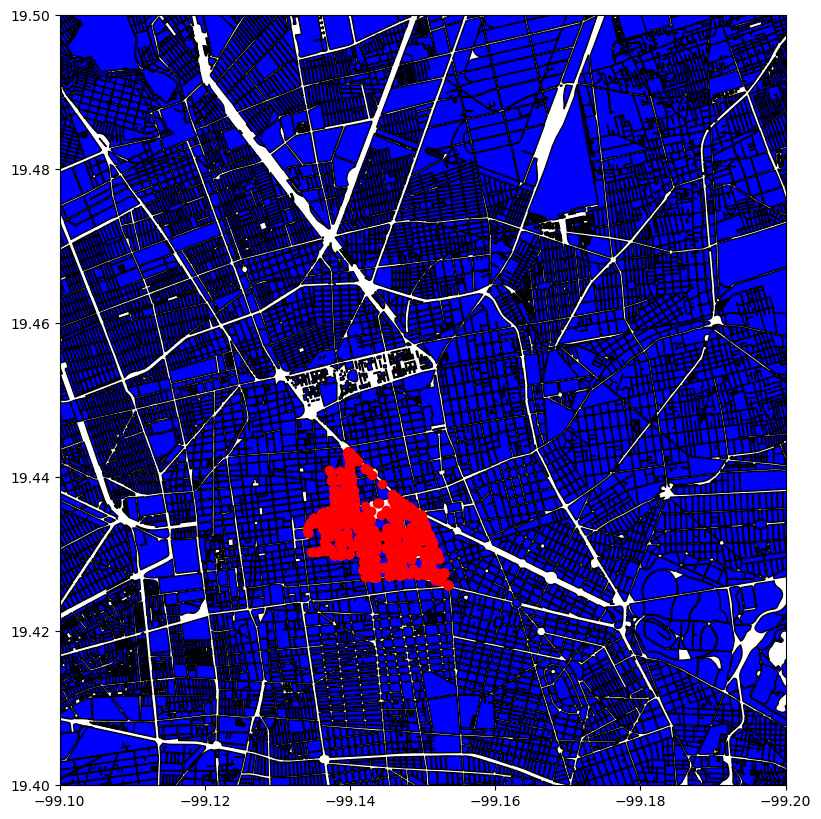

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the points
gdf.plot(ax=ax, color='red')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.10, -99.20])
ax.set_ylim([19.4, 19.5])

plt.show()


## Zoom in more

<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

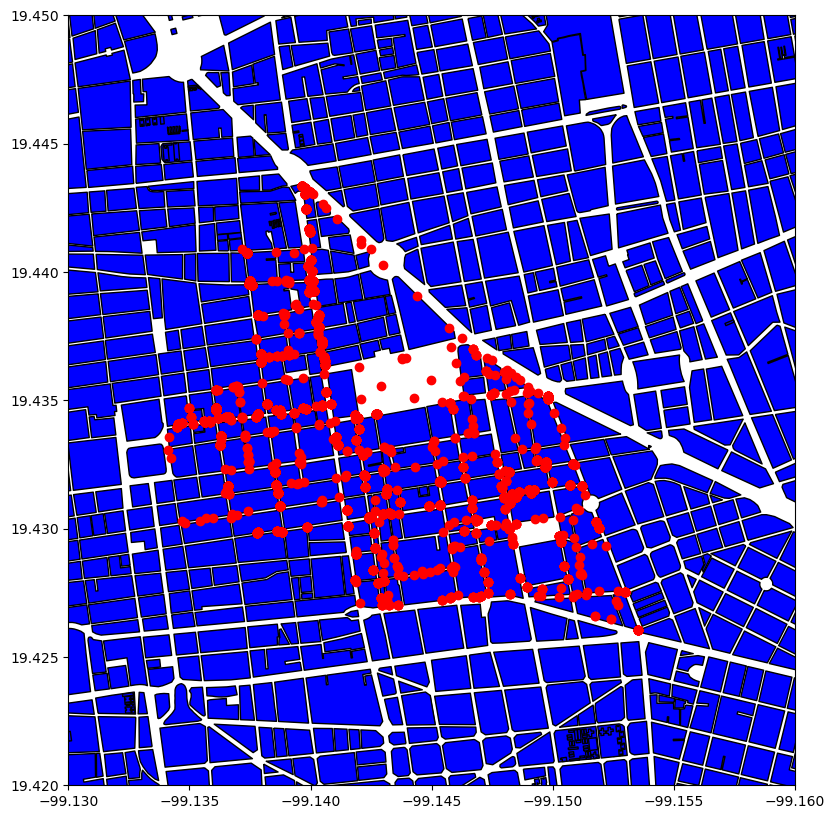

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the points
gdf.plot(ax=ax, color='red')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])

plt.show()



In [ ]:
gdf.geometry.is_valid.count

In [12]:
print(joined['index_right'].isna().sum())
print(joined['index_right'].count())

7628
4056


<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

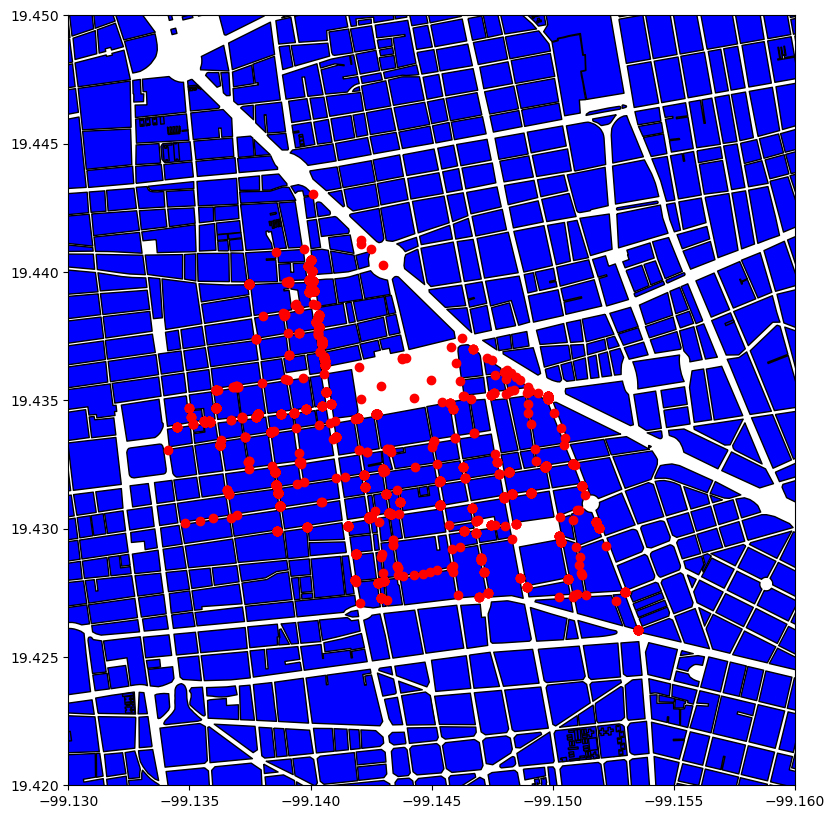

In [15]:
unmatched = gdf[joined['index_right'].isna()]

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='black')

# Plot the unmatched points
unmatched.plot(ax=ax, color='red')

ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
plt.show()



Since the points are falling on the streets and not within the blocks, we will use a buffer around the points to include a surrounding area, which may intersect with the blocks. This can help accommodate points that fall on the streets but are still functionally "within" a block. The currentcoordinate system EPSG:4326, which uses degrees as its unit. This is not the most intuitive approach when trying to create a buffer. We will convert to Universal Transverse Mercator which uses meters instead of degrees. The UTM Zone for Mexico City is EPSG code 32614.

In [16]:
# Convert the CRS of your geodataframes to EPSG:32614
gdf1 = gpd.GeoDataFrame(data, geometry='geometry')
gdf1 = gdf.to_crs(epsg=32614)
blocks = blocks.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf1['geometry'] = gdf1.geometry.buffer(5) # 5 meters as buffer size

# Re-do the spatial join
joined1 = gpd.sjoin(gdf1, blocks, how='left', op='intersects')


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Let's compare NaN values and plot again.

In [32]:
print(joined1['index_right'].isna().sum())
print(joined1['index_right'].count())

1939
10435


<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.42, 19.45)

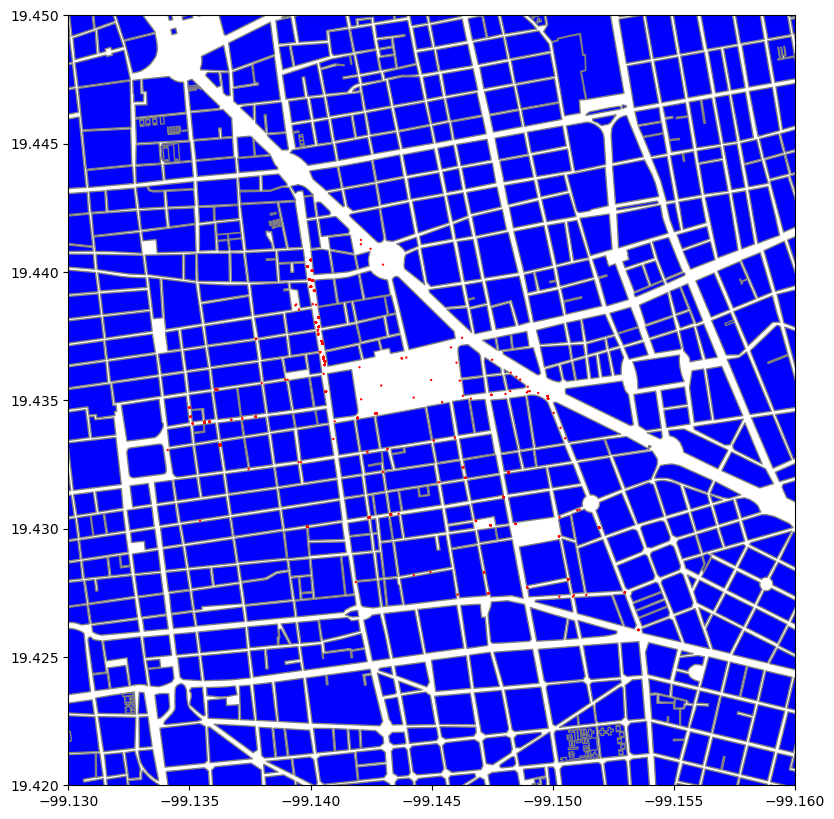

In [49]:
blocks = blocks.to_crs(epsg=4326)


unmatched1 = joined1[joined1['index_right'].isna()]
unmatched1 = unmatched1.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

# Plot the unmatched points
unmatched1.plot(ax=ax, color='red')
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.42, 19.45])
plt.show()

We can see that there are few points that are not matched to a block. We will do the join again with a buffer size of 15 meters to assign points on streets to blocks. However, if there are unmatched points after buffer=15, we will not increase the buffer size any further. This is because if the buffer size is too large then points may be assigned to multiple blocks, which would introduce bias into our analysis later on.

In [54]:
# Convert the CRS of your geodataframes to EPSG:32614
gdf2 = gpd.GeoDataFrame(data, geometry='geometry')
gdf2 = gdf.to_crs(epsg=32614)
blocks = blocks.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf2['geometry'] = gdf2.geometry.buffer(15) # 15 meters as buffer size

# Re-do the spatial join
joined2 = gpd.sjoin(gdf2, blocks, how='left', op='intersects')

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [55]:
print(joined2['index_right'].isna().sum())
print(joined2['index_right'].count())

34
22464


We can see that the ratio of unmatched points to matched points is only 0.001, which is an acceptable degree.

In [57]:
unmatched_count = joined2['index_right'].isna().sum()
matched_count = joined2['index_right'].count()

# Calculate ratio
ratio = unmatched_count / matched_count

print(f"Ratio of unmatched points to matched points: {ratio}")


Ratio of unmatched points to matched points: 0.0015135327635327634


<AxesSubplot:>

<AxesSubplot:>

(-99.14, -99.155)

(19.425, 19.443)

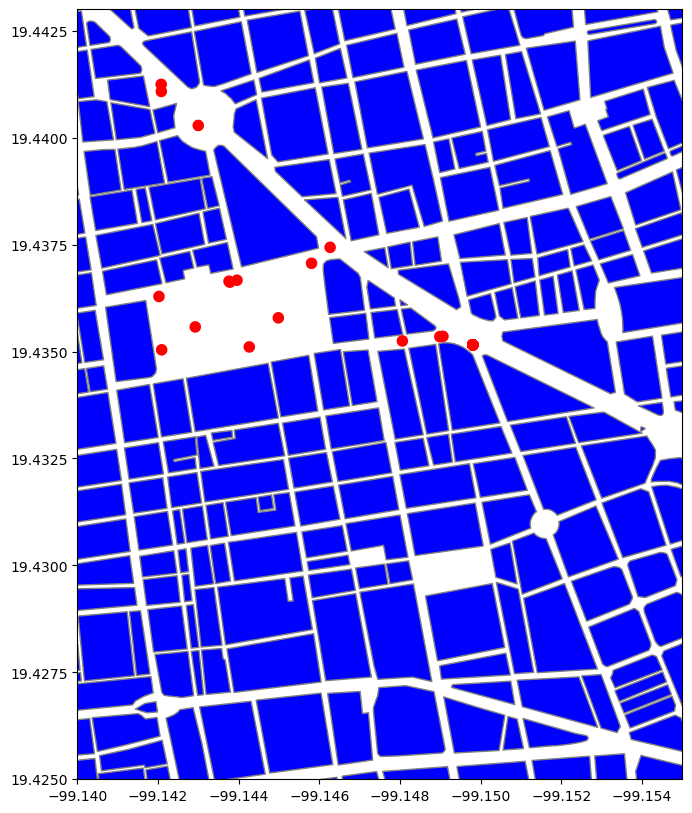

In [56]:
blocks = blocks.to_crs(epsg=4326)


unmatched2 = joined2[joined2['index_right'].isna()]
unmatched2 = unmatched2.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')

# Plot the unmatched points
unmatched2.plot(ax=ax, color='red')
ax.set_xlim([-99.140, -99.155])
ax.set_ylim([19.425, 19.443])
plt.show()

## Processing Joined 2

In [59]:
joined2.drop(['index_right','CVEGEO','CVE_ENT','CVE_MUN','CVE_LOC','CVE_AGEB','CVE_MZA',
              'AMBITO','TIPOMZA','Unnamed: 0'],
             axis=1, inplace=True)

We will remove rows where all columns apart from the 'geometry' column are identical. We do this so that the same point is not included in multiple blocks.

In [62]:
cols_to_check = joined2.columns.difference(['geometry'])
joined2 = joined2.drop_duplicates(subset=cols_to_check, keep='first')


In [63]:
joined2.head(3)

Latitude  Longitude street_name  Storefront  Visible Sign of Business  \
0  19.435848 -99.148059    Humboldt           0                         0   
1  19.435355 -99.148250    Humboldt           0                         0   
2  19.435401 -99.148391    Humboldt           0                         0   

   Business WiFi  Business tables  Business Plugs  Business Internal CCTV  \
0              0                0               0                       0   
1              0                0               0                       0   
2              0                0               0                       0   

   External CCTV  Number of female employees  Accepts credit card  \
0              0                           0                    0   
1              0                           0                    0   
2              0                           0                    0   

  Name of Business Time Open Time Close Pictures Business Owner District  \
0                0         0          0        0              0        0   
1                0         0          0        0              0        0   
2                0         0          0        0              0        0   

  Neighborhood  C_Score T_Score  Incline  Width  Ramp conditions  \
0            0      5.5       0        2      2                1   
1            0      5.5       0        2      2                1   
2            0      5.5       0        2      2                1   

   Ramp // Crosswalk  Ramp obstacles  Crosswalk width  Vertical signs  \
0                  1               0                2               0   
1                  1               0                2               0   
2                  1               0                2               0   

   Crossing length  Access to people with disabilities  W_Score  \
0                1                                   0      5.5   
1                1                                   0      5.5   
2                1                                   0      5.5   

   Broken public property  Incivility  Obstacles  \
0                       0           0          0   
1                       0           0          1   
2                       0           0          0   

   Physical aspects in poor condition  Poor infrastructure  Positive elements  \
0                                   1                    0                  0   
1                                   0                    0                  0   
2                                   1                    0                  0   

   Broken drain-cover  Drug addicts  Federal Judiciary  Panic button  \
0                   0             0                  0             0   
1                   0             0                  0             0   
2                   0             0                  0             0   

   Vandalism  graffiti  homelessness  inclined ramp  indication of security  \
0          0         0             0              0                       0   
1          0         0             0              0                       0   
2          1         0             0              0                       0   

   mobile vendors  police presence  risky building  risky pavement  \
0               0                0               1               0   
1               0                0               1               0   
2               0                0               0               0   

   risky road  tourist map  trash  vehicle abandoned  \
0           0            0      0                  0   
1           0            0      0                  0   
2           0            0      0                  0   

   excellent street lighting  good street lighting  regular street lighting  \
0                          0                     0                        0   
1                          0                     0                        0   
2                          0                     0                        0   

   Cof

In [64]:
joined2.shape

(2410, 68)

# Join with WiFi Access Points

In [65]:
WiFi= pd.read_csv('/project/WiFi/wifi_access_points.csv')

In [69]:
WiFi.head(3)

latitud      longitud
0  19.362606  -99.25295626
1  19.352540     -99.01039
2  19.351251  -99.00999147

We only need the latitudes and longitudes from this dataset, so we will drop all other columns.

In [68]:
WiFi.drop(['id','programa','fecha_instalacion','colonia','alcaldia'],
             axis=1, inplace=True)

We will now create a new DataFrame for unique combinations of latitude and longitude to count how many WiFi points there are for each coordinate.

In [81]:
WiFi_counts = WiFi.groupby(['latitud', 'longitud']).size().reset_index(name='WiFi')
WiFi_counts.head(3)

latitud   longitud  WiFi
0  19.12339  -99.18389     1
1  19.13010     -99.18     1
2  19.13020   -99.1802     1

In [83]:
WiFi_counts.rename(columns={'latitud': 'Latitude', 'longitud':'Longitude'}, inplace=True)

In [121]:
WiFi_counts.head(3)

Latitude  Longitude  WiFi                   geometry
0  19.12339  -99.18389     1  POINT (99.18389 19.12339)
1  19.13010  -99.18000     1      POINT (99.18 19.1301)
2  19.13020  -99.18020     1    POINT (99.1802 19.1302)

We will clean up the coordinates by removing spaces and other non-digit, non-dot characters, converting them into float type.

In [111]:
def clean_coordinate(coord):
    # Check if it is a negative number
    if str(coord).strip().startswith('-'):
        is_negative = True
    else:
        is_negative = False

    # Keep only digits and dots
    cleaned = ''.join(ch for ch in str(coord) if ch.isdigit() or ch == '.')

    # Convert to float
    try:
        if is_negative:
            return -float(cleaned)
        else:
            return float(cleaned)
    except ValueError:
        # Return NaN if the conversion fails
        return np.nan




In [112]:
WiFi_counts['Latitude'] = WiFi_counts['Latitude'].apply(clean_coordinate)
WiFi_counts['Longitude'] = WiFi_counts['Longitude'].apply(clean_coordinate)


In [117]:
def make_negative(number):
    return -abs(number)


In [120]:
WiFi_counts['Longitude'] = WiFi_counts['Longitude'].apply(make_negative)


For the WiFi points we use a larger buffer size as the data is not as granular, as WiFi access points have a wide range where they provide access to.

In [136]:
# Convert the CRS of your geodataframes to EPSG:32614
WiFi_counts['geometry'] = WiFi_counts.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_wifi = gpd.GeoDataFrame(WiFi_counts, geometry='geometry', crs="EPSG:4326")
gdf_wifi = gdf_wifi.to_crs(epsg=32614)
joined2 = joined2.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf_wifi['geometry'] = gdf_wifi.geometry.buffer(60) # 60 meters as buffer size

# Re-do the spatial join
joined_wifi = gpd.sjoin(joined2,gdf_wifi, how='left', op='intersects')

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [123]:
joined_wifi.head()

Latitude_left  Longitude_left                  street_name  Storefront  \
0      19.435848      -99.148059                     Humboldt           0   
1      19.435355      -99.148250                     Humboldt           0   
2      19.435401      -99.148391                     Humboldt           0   
3      19.435526      -99.148976               Avenida Juárez           1   
4      19.435806      -99.148663  Avenida Paseo de la Reforma           0   

   Visible Sign of Business  Business WiFi  Business tables  Business Plugs  \
0                         0              0                0               0   
1                         0              0                0               0   
2                         0              0                0               0   
3                         1              1                1               1   
4                         0              0                0               0   

   Business Internal CCTV  External CCTV  Number of female employees  \
0                       0              0                           0   
1                       0              0                           0   
2                       0              0                           0   
3                       1              1                           3   
4                       0              0                           0   

   Accepts credit card   Name of Business   Time Open   Time Close  \
0                    0                  0           0            0   
1                    0                  0           0            0   
2                    0                  0           0            0   
3                    0  Coffee shop Regis  7:00:00 am  10:00:00 am   
4                    0                  0           0            0   

                                            Pictures Business Owner  \
0                                                  0              0   
1                                                  0              0   
2                                                  0              0   
3  https://drive.google.com/open?id=1xCd4QTfy10RP...     Gaby Lopez   
4                                                  0              0   

     District Neighborhood  C_Score T_Score  Incline  Width  Ramp conditions  \
0           0            0      5.5       0        2      2                1   
1           0            0      5.5       0        2      2                1   
2           0            0      5.5       0        2      2                1   
3  Cuauhtémoc       Centro      0.0       0        0      0                0   
4           0            0      0.0       0        0      0                0   

   Ramp // Crosswalk  Ramp obstacles  Crosswalk width  Vertical signs  \
0                  1               0                2               0   
1                  1               0                2               0   
2                  1               0                2               0   
3                  0               0                0               0   
4                  0               0                0               0   

   Crossing length  Access to people with disabilities  W_Score  \
0                1                                   0      5.5   
1                1                                   0      5.5   
2                1                                   0      5.5   
3                0                                   0      0.0   
4                0                                   0      0.0   

   Broken public property  Incivility  Obstacles  \
0                       0           0          0   
1                       0           0          1   
2                       0           0          0   
3                       0           0          1   
4                       1           0          0   

   Physical aspects in poor condition  Poor infrastructure  Positive elements  \
0                                   1                    0         

In [103]:
gdf_wifi.head()

Latitude  Longitude  WiFi  \
0  19.123390  99.183890     1   
1  19.130100  99.180000     1   
2  19.130200  99.180200     1   
3  19.131999  99.170721     1   
4  19.134200  99.172300     1   

                                            geometry  
0  POLYGON ((99.18375 19.12340, 99.18376 19.12342...  
1  POLYGON ((99.17986 19.13011, 99.17987 19.13013...  
2  POLYGON ((99.18006 19.13021, 99.18007 19.13023...  
3  POLYGON ((99.17059 19.13201, 99.17059 19.13203...  
4  POLYGON ((99.17216 19.13421, 99.17217 19.13423...

<AxesSubplot:>

<AxesSubplot:>

(-99.13, -99.16)

(19.425, 19.443)

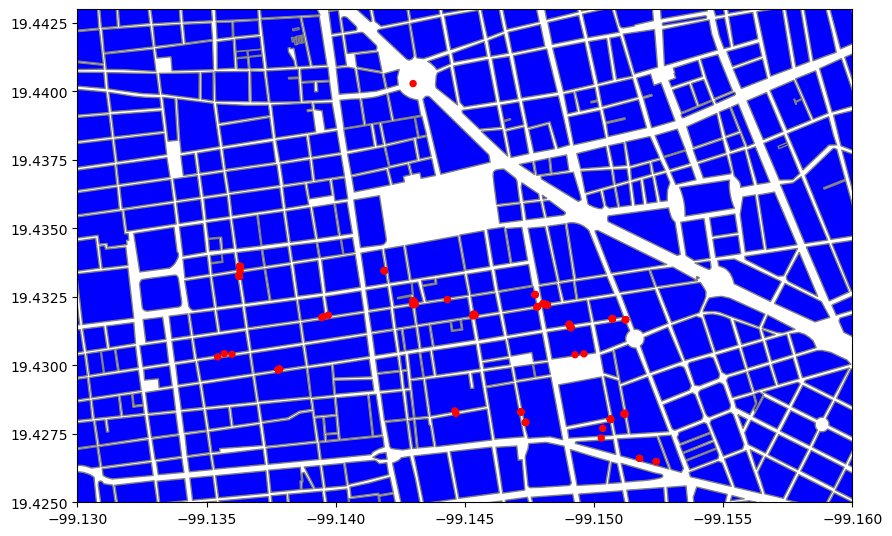

In [138]:


unmatched_wifi = joined_wifi[joined_wifi['index_right'].isna()]
unmatched_wifi = unmatched_wifi.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)

blocks.plot(ax=ax, color='blue', edgecolor='grey')
# Plot the unmatched points
unmatched_wifi.plot(ax=ax, color='red')
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

plt.show()


In [137]:
print(joined_wifi['index_right'].isna().sum())
print(joined_wifi['index_right'].count())

215
3961


We will now remove duplicate rows.

In [139]:
cols_to_check_wifi = joined_wifi.columns.difference(['geometry'])
joined_wifi = joined_wifi.drop_duplicates(subset=cols_to_check_wifi, keep='first')

In [149]:
joined_wifi.head(3)

Latitude  Longitude street_name  Storefront  Visible Sign of Business  \
0  19.435848 -99.148059    Humboldt           0                         0   
0  19.435848 -99.148059    Humboldt           0                         0   
0  19.435848 -99.148059    Humboldt           0                         0   

   Business WiFi  Business tables  Business Plugs  Business Internal CCTV  \
0              0                0               0                       0   
0              0                0               0                       0   
0              0                0               0                       0   

   External CCTV  Number of female employees  Accepts credit card  \
0              0                           0                    0   
0              0                           0                    0   
0              0                           0                    0   

  Name of Business Time Open Time Close Pictures Business Owner District  \
0                0         0          0        0              0        0   
0                0         0          0        0              0        0   
0                0         0          0        0              0        0   

  Neighborhood  C_Score T_Score  Incline  Width  Ramp conditions  \
0            0      5.5       0        2      2                1   
0            0      5.5       0        2      2                1   
0            0      5.5       0        2      2                1   

   Ramp // Crosswalk  Ramp obstacles  Crosswalk width  Vertical signs  \
0                  1               0                2               0   
0                  1               0                2               0   
0                  1               0                2               0   

   Crossing length  Access to people with disabilities  W_Score  \
0                1                                   0      5.5   
0                1                                   0      5.5   
0                1                                   0      5.5   

   Broken public property  Incivility  Obstacles  \
0                       0           0          0   
0                       0           0          0   
0                       0           0          0   

   Physical aspects in poor condition  Poor infrastructure  Positive elements  \
0                                   1                    0                  0   
0                                   1                    0                  0   
0                                   1                    0                  0   

   Broken drain-cover  Drug addicts  Federal Judiciary  Panic button  \
0                   0             0                  0             0   
0                   0             0                  0             0   
0                   0             0                  0             0   

   Vandalism  graffiti  homelessness  inclined ramp  indication of security  \
0          0         0             0              0                       0   
0          0         0             0              0                       0   
0          0         0             0              0                       0   

   mobile vendors  police presence  risky building  risky pavement  \
0               0                0               1               0   
0               0                0               1               0   
0               0                0               1               0   

   risky road  tourist map  trash  vehicle abandoned  \
0           0            0      0                  0   
0           0            0      0                  0   
0           0            0      0                  0   

   excellent street lighting  good street lighting  regular street lighting  \
0                          0                     0                        0   
0                          0                     0                        0   
0                          0                     0                        0   

   Cof

We also don't need the exact coordinates of the wifi access points, hence we will drop these columns.

In [143]:
joined_wifi.drop(['index_right','Latitude_right','Longitude_right'],
             axis=1, inplace=True)

In [145]:
joined_wifi.rename(columns={'Latitude_left': 'Latitude', 'Longitude_left':'Longitude',
                           'WiFi':'Public WiFi'}, inplace=True)

# Join with Electric Bike Points

In [150]:
bikes = pd.read_csv('/project/bikes/electrict_bike_points.csv')

In [162]:
bikes.head(3)

Latitude  Longitude  number of bikes
0  19.43359 -99.167819               27
1  19.43051 -99.171201               21
2  19.43163 -99.158547               36

We only need the coordinates and the number of bike stations (locks) for each location. Therefore we will drop the other columns.

In [155]:
bikes.drop(['sistema','num_cicloestacion','nombre','calle_principal','calle_secundaria',
            'colonia','alcaldia','tipo_ce'],
             axis=1, inplace=True)

We will then clean the coordinates.

In [158]:
bikes.rename(columns={'latitud': 'Latitude', 'longitud':'Longitude','candados': 'number of bikes'}, inplace=True)

In [159]:
bikes['Latitude'] = bikes['Latitude'].apply(clean_coordinate)
bikes['Longitude'] = bikes['Longitude'].apply(clean_coordinate)

In [173]:
# Convert the CRS of your geodataframes to EPSG:32614
bikes['geometry'] = bikes.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_bikes = gpd.GeoDataFrame(bikes, geometry='geometry', crs="EPSG:4326")
gdf_bikes = gdf_bikes.to_crs(epsg=32614)
joined_wifi = joined_wifi.to_crs(epsg=32614)

# Create a buffer around your points
# Here, the buffer size is in meters
gdf_bikes['geometry'] = gdf_bikes.geometry.buffer(30) # 30 meters as buffer size

# Do the spatial join
joined_bikes = gpd.sjoin(joined_wifi,gdf_bikes, how='left', op='intersects')

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


The number of stations that have not been joined is high, however this makes sense as the number of bike stations are expected to be considerably less than the other factors we have in the data.

In [174]:
print(joined_bikes['index_right'].isna().sum())
print(joined_bikes['index_right'].count())

3942
234


<AxesSubplot:>

<AxesSubplot:>

(-99.12, -99.18)

(19.4, 19.45)

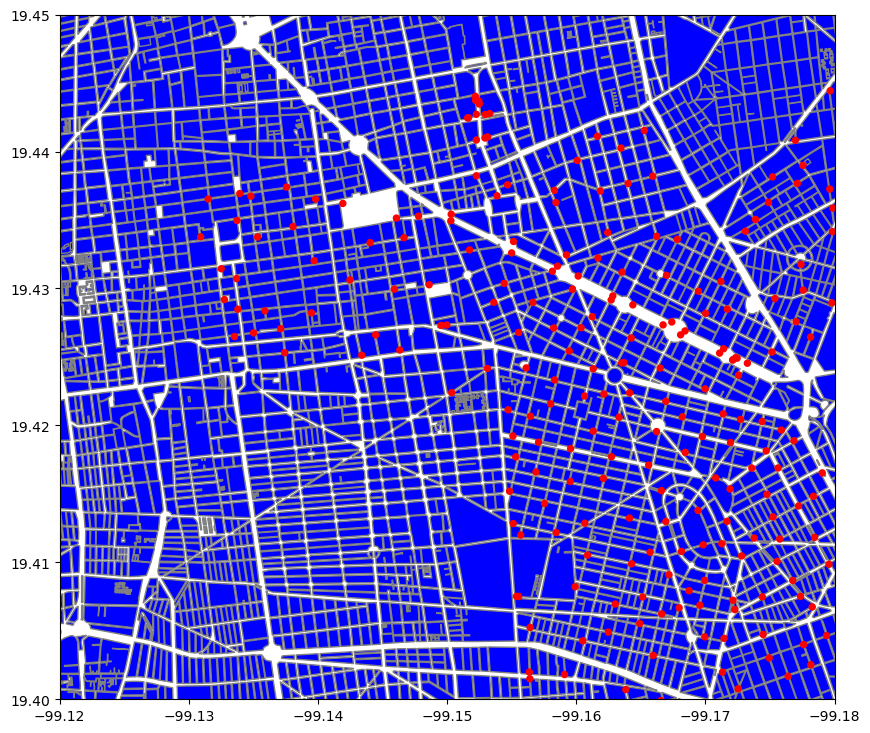

In [179]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)
blocks.plot(ax=ax, color='blue', edgecolor='grey')
gdf_bikes = gdf_bikes.to_crs(epsg=4326)
# Plot the points
gdf_bikes.plot(ax=ax, color='red')

# Adjust x and y limits (longitude, latitude) to zoom into an area
# Replace these values with the actual range you're interested in
ax.set_xlim([-99.12, -99.18])
ax.set_ylim([19.40, 19.45])

plt.show()

In [ ]:


unmatched_wifi = joined_wifi[joined_wifi['index_right'].isna()]
unmatched_wifi = unmatched_wifi.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the blocks (polygons)

blocks.plot(ax=ax, color='blue', edgecolor='grey')
# Plot the unmatched points
unmatched_wifi.plot(ax=ax, color='red')
ax.set_xlim([-99.13, -99.16])
ax.set_ylim([19.425, 19.443])

plt.show()